In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
 import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [5]:
pip install tensorflow


   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 1.0/390.3 MB 5.6 MB/s eta 0:01:10
   ---------------------------------------- 2.6/390.3 MB 6.3 MB/s eta 0:01:02
   ---------------------------------------- 4.2/390.3 MB 7.0 MB/s eta 0:00:56
    --------------------------------------- 6.0/390.3 MB 7.5 MB/s eta 0:00:52
    --------------------------------------- 7.9/390.3 MB 7.7 MB/s eta 0:00:50
    --------------------------------------- 9.4/390.3 MB 7.7 MB/s eta 0:00:50
   - -------------------------------------- 11.0/390.3 MB 7.7 MB/s eta 0:00:50
   - -------------------------------------- 12.6/390.3 MB 7.7 MB/s eta 0:00:49
   - -------------------------------------- 14.4/390.3 MB 7.9 MB/s eta 0:00:48
   - -------------------------------------- 16.3/390.3 MB 7.9 MB/s eta 0:00:48
   - -------------------------------------- 18.4/390.3 MB 8.1 MB/s eta 0:00:46
   -- ------------------------------------- 20.4/390.3 MB 8.3 MB/s

In [9]:
data_dir = 'D:/archive/BananaLSD/AugmentedSet'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [11]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [13]:
class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

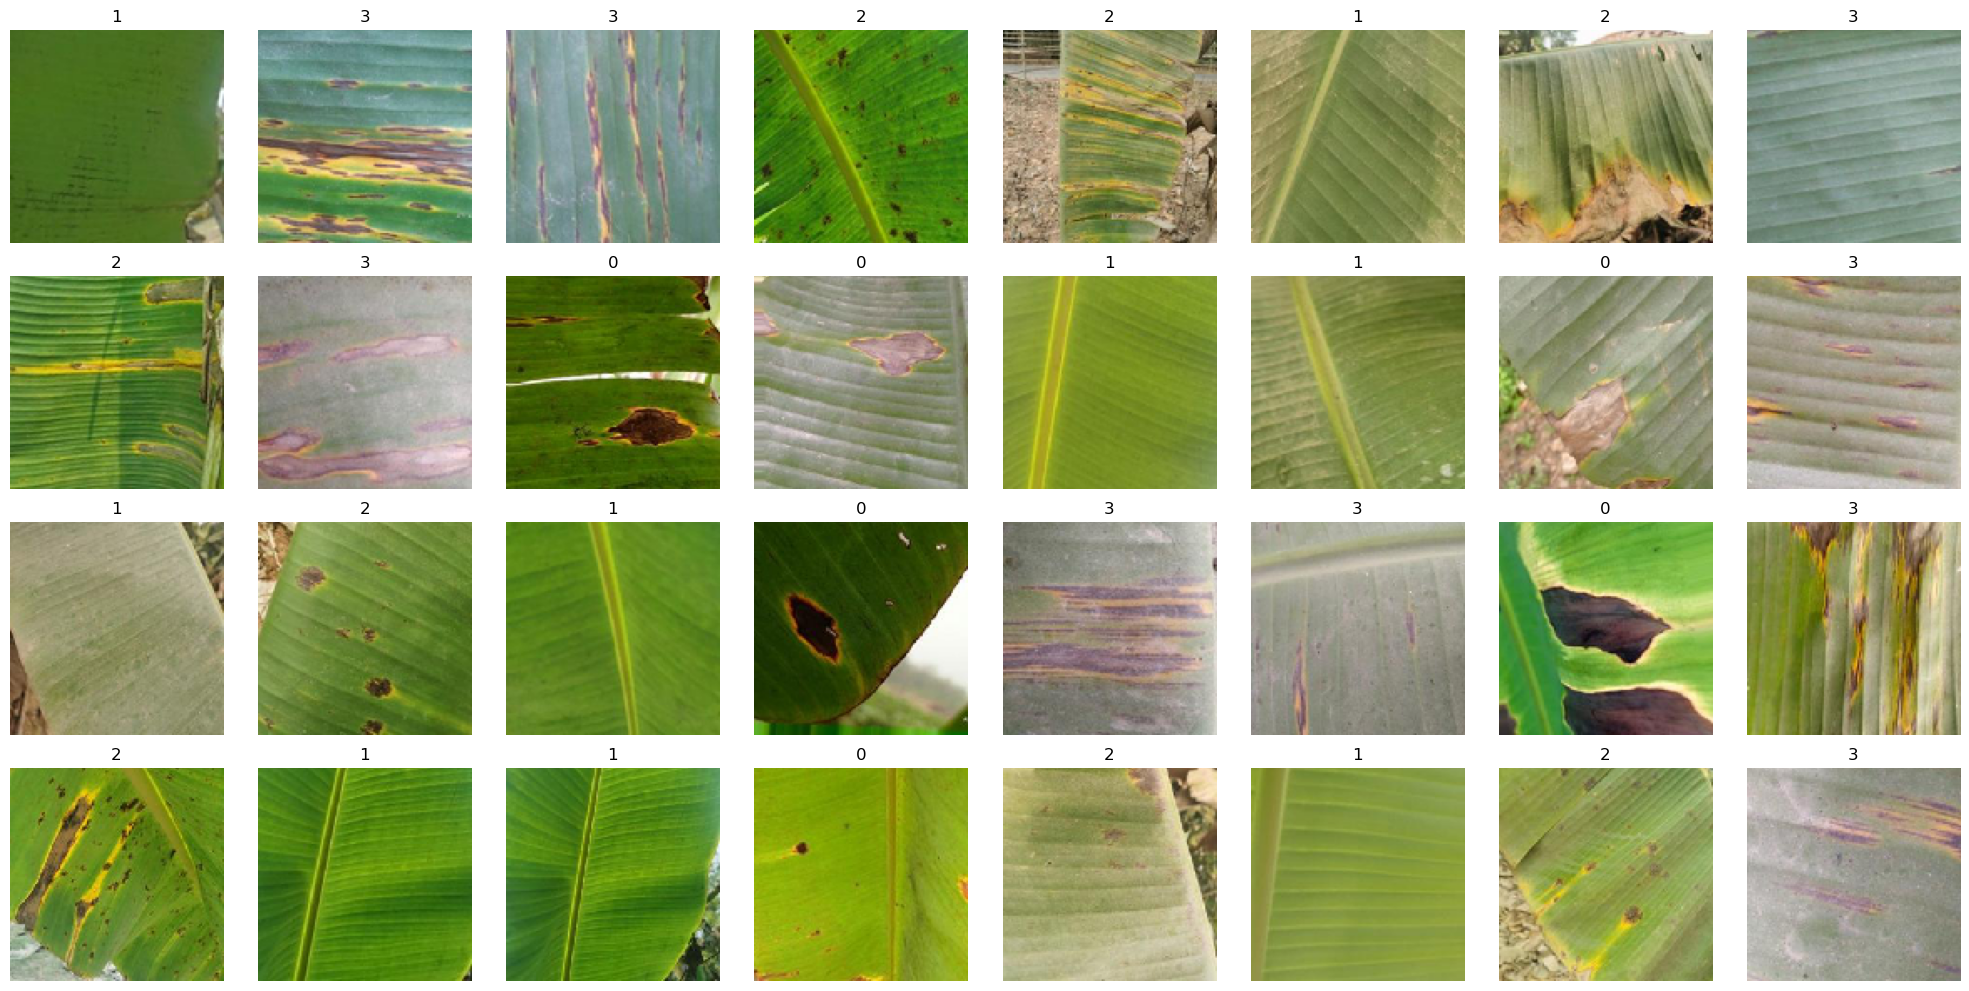

In [15]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [19]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

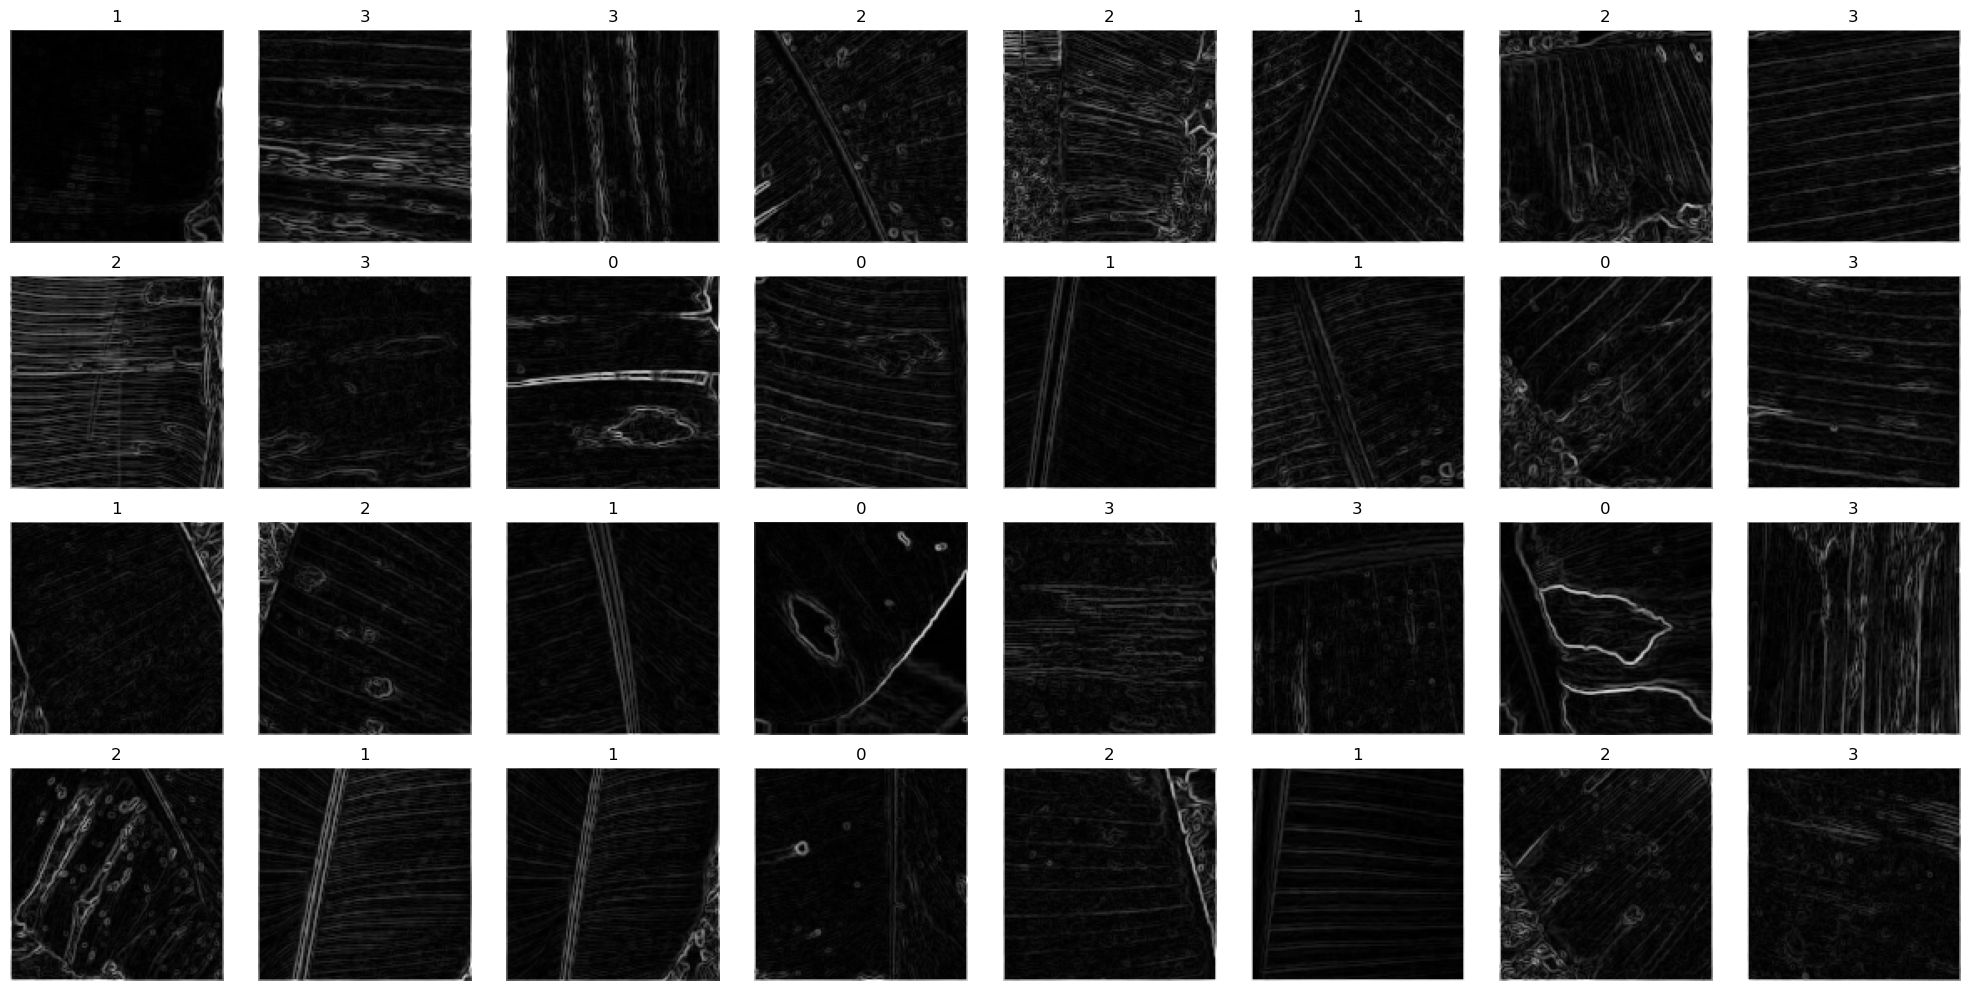

In [21]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [23]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

CNN Model

In [26]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(4, activation='softmax')
])

In [28]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,274,916 (4.86 MB)

 Trainable params: 1,273,188 (4.86 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [95]:
history_lenet = model_lenet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 571ms/step - accuracy: 0.9870 - loss: 0.0505 - val_accuracy: 0.8188 - val_loss: 0.6471
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 546ms/step - accuracy: 0.9774 - loss: 0.0831 - val_accuracy: 0.8844 - val_loss: 0.4540
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 579ms/step - accuracy: 0.9757 - loss: 0.0836 - val_accuracy: 0.8625 - val_loss: 0.6895
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 578ms/step - accuracy: 0.9816 - loss: 0.0541 - val_accuracy: 0.8344 - val_loss: 0.7157
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - accuracy: 0.9857 - loss: 0.0536 - val_accuracy: 0.7688 - val_loss: 1.0770
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - accuracy: 0.9823 - loss: 0.0772 - val_accuracy: 0.7344 - val_loss: 1.9711
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 539ms/step - accuracy: 0.9708 - loss: 0.0953 - val_accuracy: 0.8687 - val_loss: 0.3921
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.9770 - loss: 0.0858 - val_accu

In [ ]:
#history_lenet = model_resnet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

In [32]:
c

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 590ms/step - accuracy: 0.3564 - loss: 1.9341 - val_accuracy: 0.2500 - val_loss: 1.6610
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - accuracy: 0.4903 - loss: 1.3837 - val_accuracy: 0.2406 - val_loss: 2.7007
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 564ms/step - accuracy: 0.5941 - loss: 1.0572 - val_accuracy: 0.2500 - val_loss: 3.1478
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 558ms/step - accuracy: 0.6137 - loss: 0.9593 - val_accuracy: 0.2594 - val_loss: 1.9133
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - accuracy: 0.6336 - loss: 0.8852 - val_accuracy: 0.2344 - val_loss: 2.5392
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 560ms/step - accuracy: 0.6320 - loss: 0.9232 - val_accuracy: 0.2500 - val_loss: 3.1651
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 577ms/step - accuracy: 0.6651 - loss: 0.8303 - val_accuracy: 0.3063 - val_loss: 2.8814
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 611ms/step - accuracy: 0.7393 - loss: 0.6534 - val_accu

In [34]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [36]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(4, activation='softmax')
])

In [38]:
base_model_resnet.trainable = False
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,012 (90.98 MB)

 Trainable params: 263,044 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [42]:
history_resnet = model_resnet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 513ms/step - accuracy: 0.4493 - loss: 1.2258 - precision_1: 0.6362 - recall_1: 0.1514 - val_accuracy: 0.3594 - val_loss: 1.6598 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - accuracy: 0.5922 - loss: 1.0158 - precision_1: 0.7240 - recall_1: 0.3813 - val_accuracy: 0.2937 - val_loss: 1.6309 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.6438 - loss: 0.9557 - precision_1: 0.7252 - recall_1: 0.3953 - val_accuracy: 0.2781 - val_loss: 1.6910 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.6837 - loss: 0.8869 - precision_1: 0.7848 - recall_1: 0.4386 - val_accuracy: 0.4156 - val_loss: 1.8719 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 463ms/step - accuracy: 0.6742 - loss: 0.8456 - pre

In [46]:
from tensorflow.keras.layers import Conv2D, concatenate

def fire_module(x, squeeze_filters, expand_filters):
    """
    Fire module for SqueezeNet
    - Squeeze layer: 1x1 convolutions
    - Expand layer: 1x1 and 3x3 convolutions
    """
    # Squeeze layer (1x1 convolutions)
    squeeze = Conv2D(filters=squeeze_filters, kernel_size=(1, 1), padding='same', activation='relu')(x)

    # Expand layer (1x1 and 3x3 convolutions)
    expand_1x1 = Conv2D(filters=expand_filters, kernel_size=(1, 1), padding='same', activation='relu')(squeeze)
    expand_3x3 = Conv2D(filters=expand_filters, kernel_size=(3, 3), padding='same', activation='relu')(squeeze)
    
    # Concatenate both branches
    return concatenate([expand_1x1, expand_3x3])


In [61]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, concatenate
from tensorflow.keras import Input, Model

# Define the Fire module as a function
def fire_module(x, squeeze_filters, expand_filters):
    """
    Fire module for SqueezeNet
    - Squeeze layer: 1x1 convolutions
    - Expand layer: 1x1 and 3x3 convolutions
    """
    squeeze = Conv2D(squeeze_filters, (1, 1), padding='same', activation='relu')(x)
    expand_1x1 = Conv2D(expand_filters, (1, 1), padding='same', activation='relu')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(squeeze)
    return concatenate([expand_1x1, expand_3x3])

# Build the SqueezeNet model
input_layer = Input(shape=(128, 128, 3))

# Initial Convolution Layer
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)

# First Fire Module
x = fire_module(x, 16, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Second Fire Module
x = fire_module(x, 32, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Third Fire Module
x = fire_module(x, 64, 256)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Fourth Fire Module
x = fire_module(x, 128, 512)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# Fully Connected Layer (Classifier)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer (4 classes)
output_layer = Dense(4, activation='softmax')(x)

# Create the model
model_squeezenet = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_squeezenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [63]:
history_squeezenet = model_squeezenet.fit(
    train_generator,  # The training data
    epochs=50,  # Number of epochs to train the model
    validation_data=val_generator  # The validation data
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.2882 - loss: 2.2688 - val_accuracy: 0.2500 - val_loss: 1.4312
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.3339 - loss: 1.7769 - val_accuracy: 0.2500 - val_loss: 1.4455
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.3200 - loss: 1.8009 - val_accuracy: 0.2500 - val_loss: 1.4669
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - accuracy: 0.4362 - loss: 1.4752 - val_accuracy: 0.2500 - val_loss: 1.5308
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.4237 - loss: 1.4567 - val_accuracy: 0.3063 - val_loss: 1.5703
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.5029 - loss: 1.1561 - val_accuracy: 0.2562 - val_loss: 1.8646
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.5039 - loss: 1.1876 - val_accuracy: 0.2719 - val_loss: 1.8834
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.5201 - loss: 1.0402 - val_accu

In [66]:
def plot_performance(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.show()

In [68]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

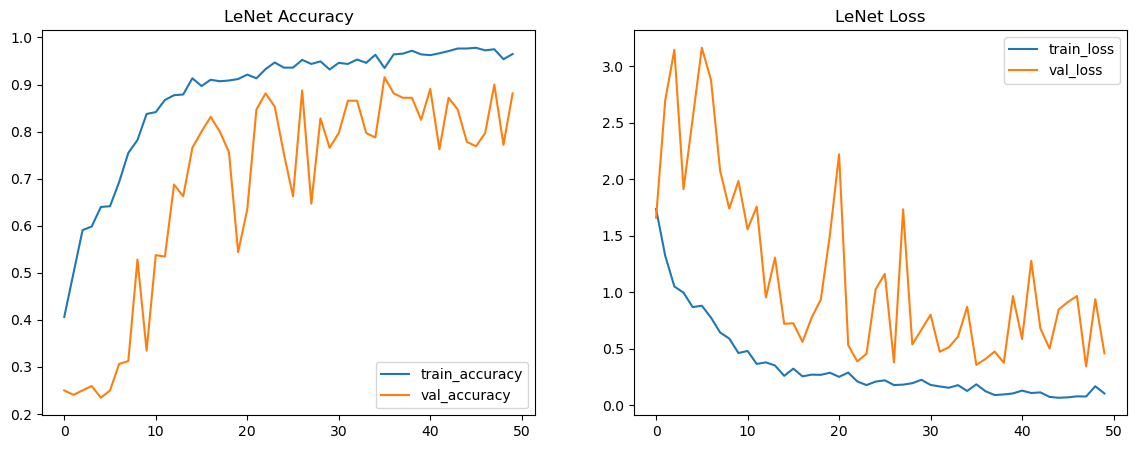

In [70]:
plot_performance(history_lenet, 'LeNet')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


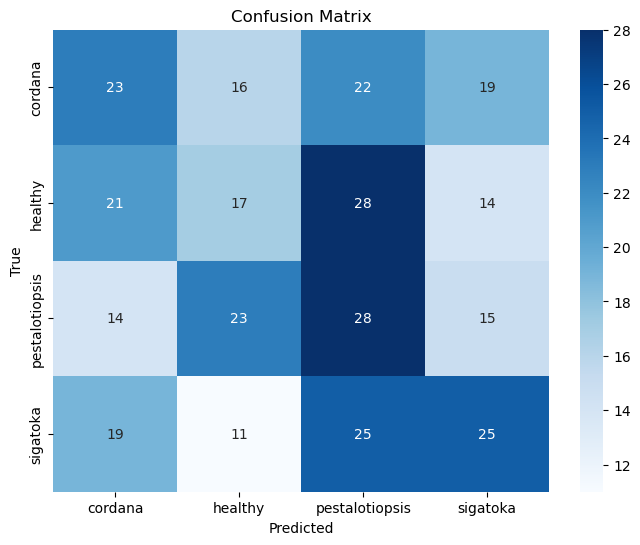

Classification Report:
                precision    recall  f1-score   support

       cordana       0.30      0.29      0.29        80
       healthy       0.25      0.21      0.23        80
pestalotiopsis       0.27      0.35      0.31        80
      sigatoka       0.34      0.31      0.33        80

      accuracy                           0.29       320
     macro avg       0.29      0.29      0.29       320
  weighted avg       0.29      0.29      0.29       320



In [72]:
evaluate_model(model_lenet, val_generator)

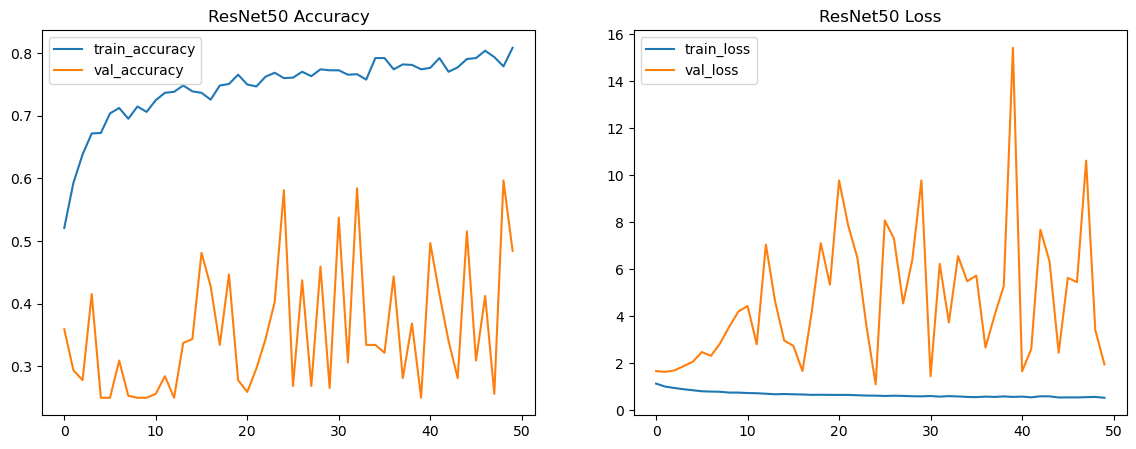

In [74]:
plot_performance(history_resnet, 'ResNet50')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step


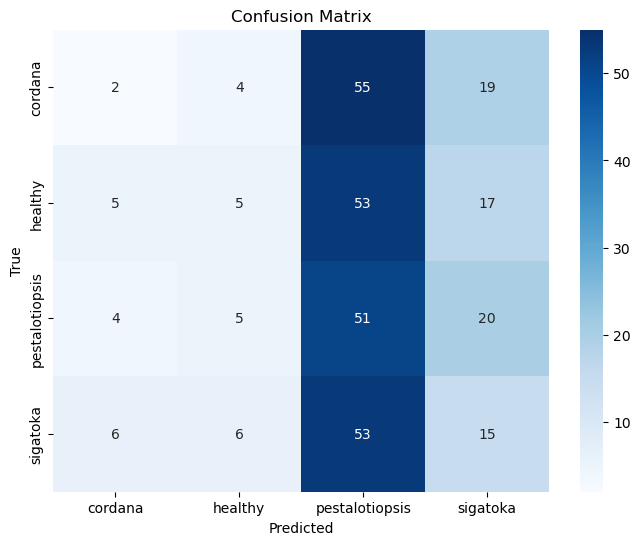

Classification Report:
                precision    recall  f1-score   support

       cordana       0.12      0.03      0.04        80
       healthy       0.25      0.06      0.10        80
pestalotiopsis       0.24      0.64      0.35        80
      sigatoka       0.21      0.19      0.20        80

      accuracy                           0.23       320
     macro avg       0.20      0.23      0.17       320
  weighted avg       0.20      0.23      0.17       320



In [76]:
evaluate_model(model_resnet, val_generator)